In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


 
# **FINAL NOTEBOOK SUBMISSION**
 
**This notebook performs:**
* EDA: Basic insights on data shape and missing values.
* Feature Engineering: Temporal features, version processing.
* Preprocessing: Pipelines with numerical and categorical transformations.
* Modeling: Three different models (XGB, LightGBM, Logistic Regression) with hyperparameter tuning.
* Model Comparison: Evaluates performance via cross-validation.
* Ensembling: Using stacking (meta-learner)
* Final Submission File creation.
* Comparison of Models

# 1. Import Basic Library

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Import necessary libraries

In [7]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.preprocessing import FunctionTransformer

# 3. Load the datasets

In [28]:
# Load data
train = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")
sample = pd.read_csv("/kaggle/input/System-Threat-Forecaster/sample_submission.csv")

# 4.Exploratory Data Analysis

In [9]:
# Initial observations
print("=== Dataset Overview ===")
print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print("\nMissing values:\n", train.isna().sum().sort_values(ascending=False).head(10))
total_missing = train.isna().sum().sum()
print(f"\nTotal missing values in train dataset: {total_missing}")
print("\nTarget distribution:\n", train['target'].value_counts(normalize=True))

=== Dataset Overview ===
Train shape: (100000, 76), Test shape: (10000, 75)

Missing values:
 SMode                             981
CityID                            623
RegionIdentifier                  559
IsGamer                           559
InternalBatteryNumberOfCharges    515
FirmwareManufacturerID            376
FirmwareVersionID                 334
IsFlightsDisabled                 326
OEMModelID                        228
OEMNameID                         212
dtype: int64

Total missing values in train dataset: 6533

Target distribution:
 target
1    0.50525
0    0.49475
Name: proportion, dtype: float64


In [10]:
# Dataset structure analysis
print("=== DataSet Structure ===")
train.info(verbose=True, show_counts=True)
print("\nData Types in dataset:\n", train.dtypes.value_counts())

=== DataSet Structure ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  H

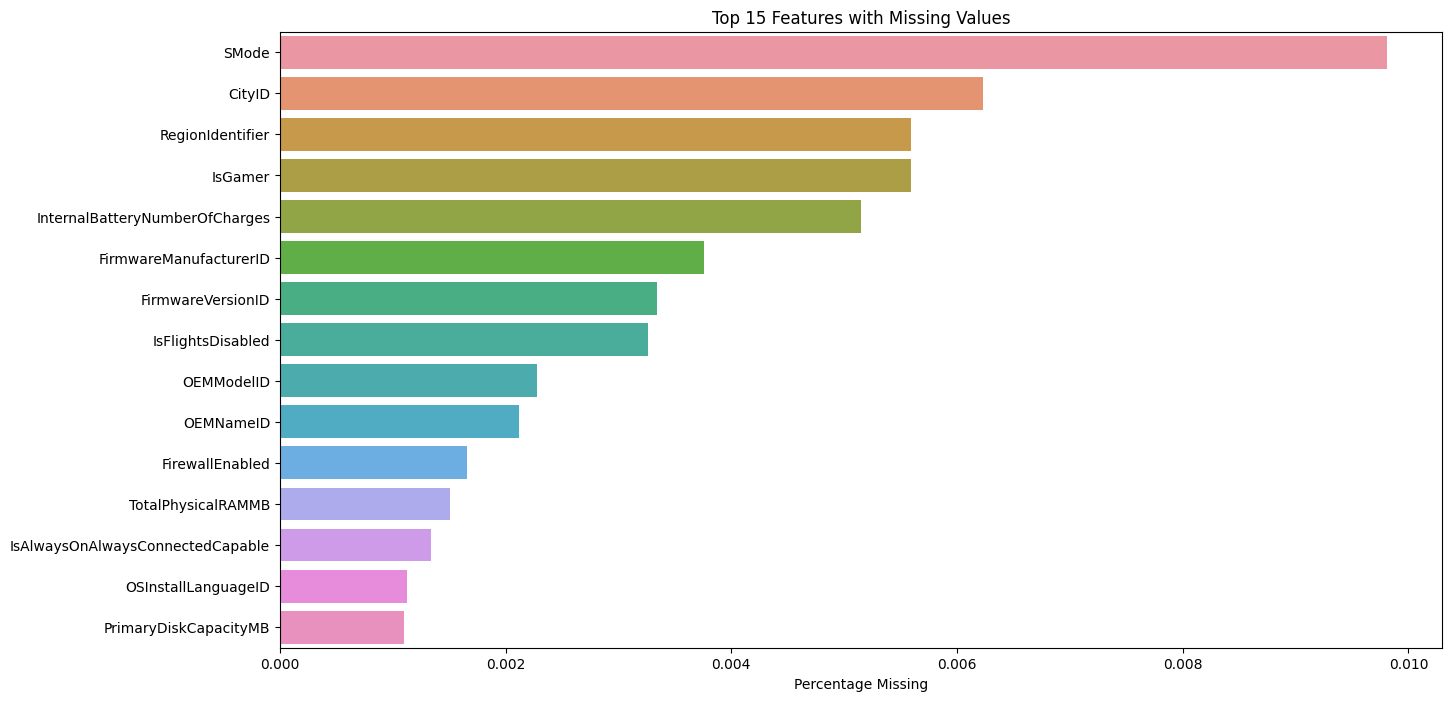

In [11]:
# Missing value visualization
plt.figure(figsize=(15, 8))
missing = train.isna().mean().sort_values(ascending=False)[:15]
sns.barplot(x=missing.values, y=missing.index)
plt.title('Top 15 Features with Missing Values')
plt.xlabel('Percentage Missing')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


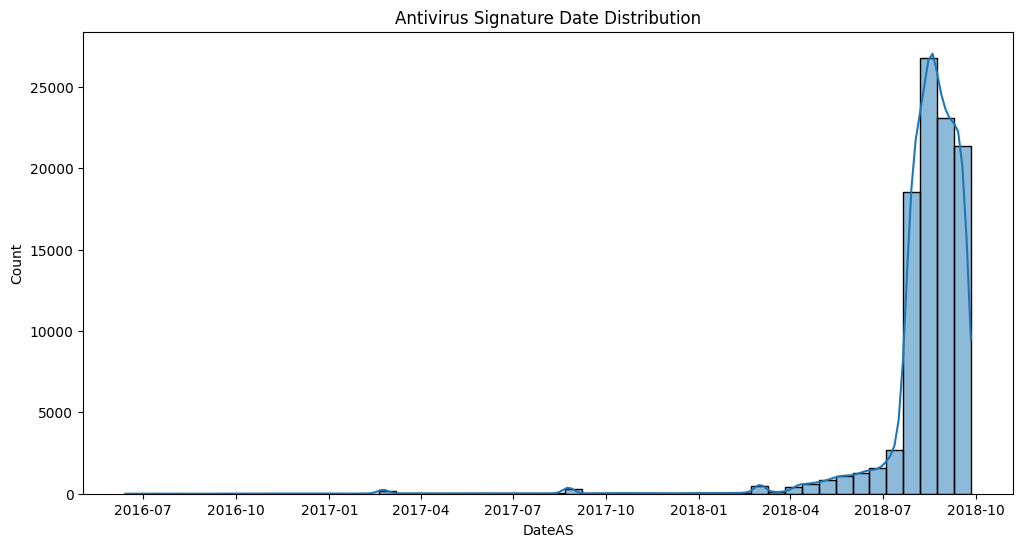

In [13]:
# Temporal feature distributions
plt.figure(figsize=(12,6))
sns.histplot(pd.to_datetime(train['DateAS']), bins=50, kde=True)
plt.title('Antivirus Signature Date Distribution')
plt.show()

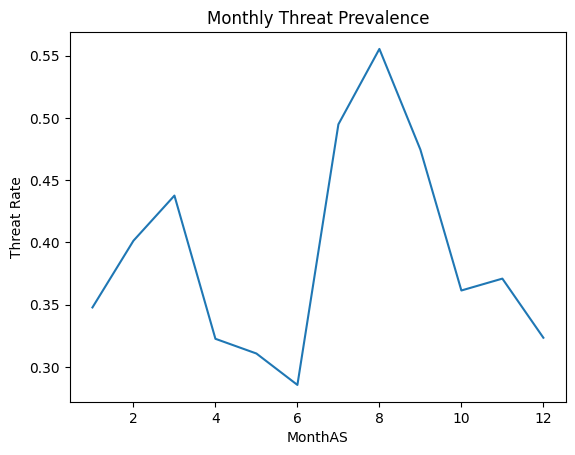

In [30]:
# Monthly threat trend
train['MonthAS'] = pd.to_datetime(train['DateAS']).dt.month
train.groupby('MonthAS')['target'].mean().plot()
plt.title('Monthly Threat Prevalence')
plt.ylabel('Threat Rate')
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


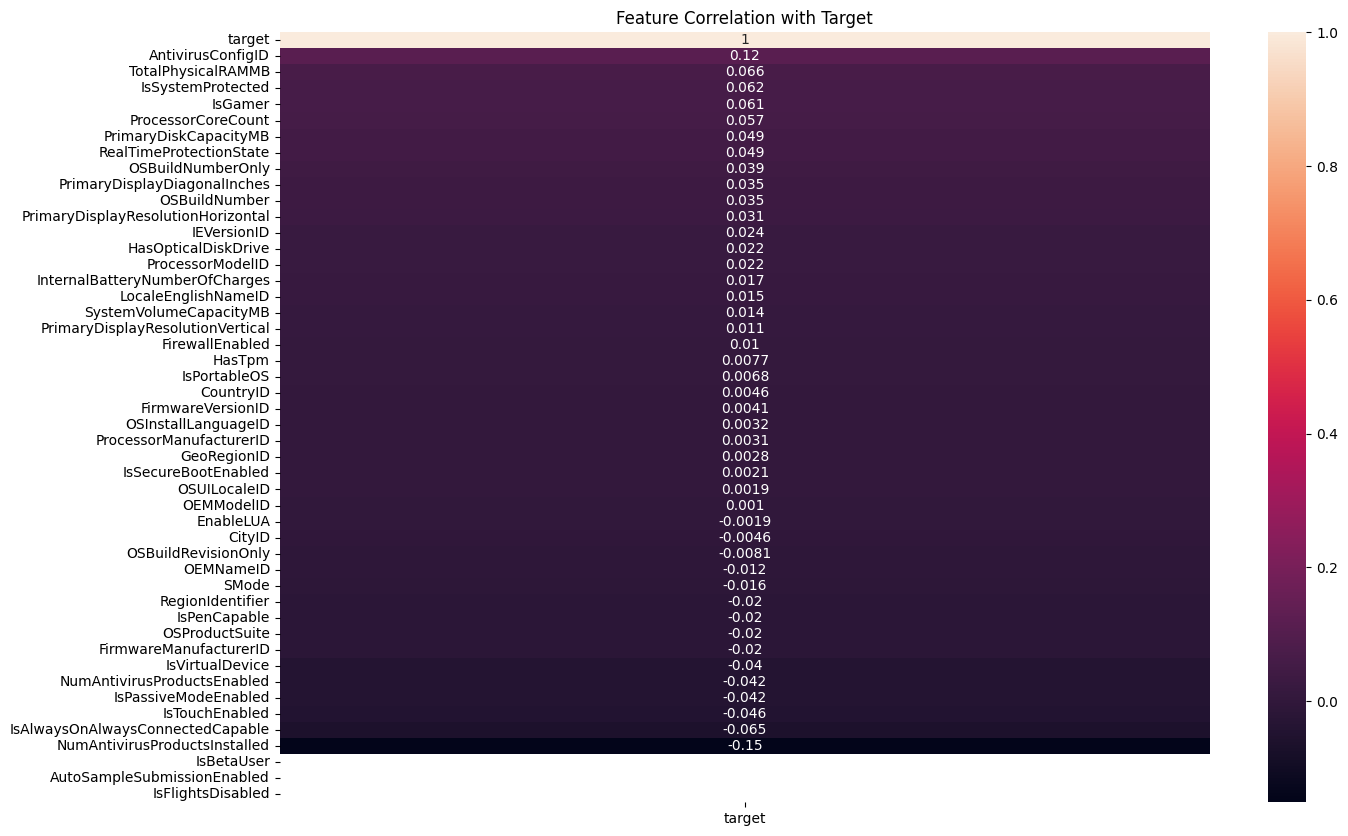

In [14]:
# Correlation analysis
corr_matrix = train.select_dtypes(include=np.number).corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix[['target']].sort_values('target', ascending=False), annot=True)
plt.title('Feature Correlation with Target')
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

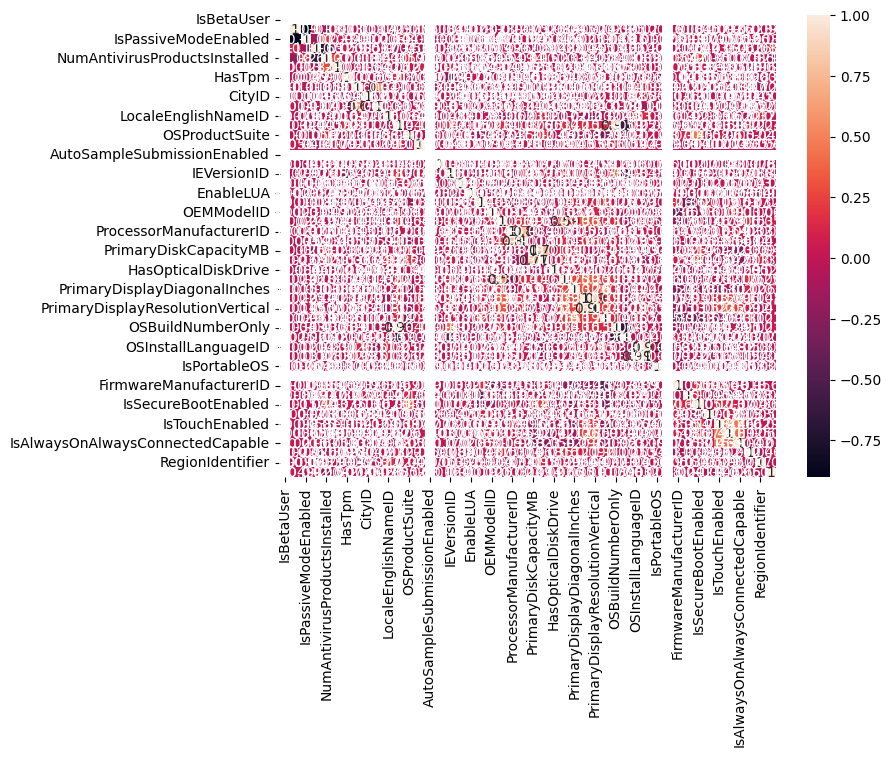

In [12]:
#Heat map
numeric = train.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train[numeric].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot= True)

### **Observation 1 : Dataset Overview & EDA**

- **Shape and Missing Values**:
    - Train: 100,000 rows × 76 columns | Test: 10,000 rows × 75 columns.
    - Missing values are concentrated in columns like `SMode` (981 missing), `CityID` (623 missing), and `InternalBatteryNumberOfCharges` (515 missing). These require imputation during preprocessing.
    - **Target Distribution**: Nearly balanced (50.5% class 1, 49.5% class 0), reducing class imbalance risks.
- **Temporal Features**:
    - `DateAS` (Antivirus Signature Date) shows a skewed distribution in the histogram, with most values clustered around specific periods. This could indicate periodic updates or events.
- **Correlation Analysis**:
    - Numerical features have weak correlations with the target (max ~0.078). This suggests individual features may not be strongly predictive, emphasizing the need for feature engineering and ensemble models.
- **Monthly Trend Analysis**:
    - From the plot it can obsereved that, the threat rate is particularly high during the 8th month.

# 5. Feature Engineering

In [15]:
# Global storage for feature engineering artifacts
feature_artifacts = {}

In [16]:
# Feature Engineering 
def process_features(df, is_train=True):
    # Temporal features
    df['DateAS'] = pd.to_datetime(df['DateAS'])
    df['DateOS'] = pd.to_datetime(df['DateOS'])
    df['AS_OS_Diff'] = (df['DateAS'] - df['DateOS']).dt.days
    df['AS_quarter'] = df['DateAS'].dt.quarter
    df['OS_quarter'] = df['DateOS'].dt.quarter
    
    # Version processing
    version_cols = ['EngineVersion', 'AppVersion', 'SignatureVersion']
    for col in version_cols:
        # Frequency encoding (with artifact storage)
        if is_train:
            freq = df[col].value_counts(normalize=True)
            feature_artifacts[f'{col}_freq'] = freq
            df[col+'_freq'] = df[col].map(freq)
        else:
            df[col+'_freq'] = df[col].map(feature_artifacts.get(f'{col}_freq', pd.Series())).fillna(0)
        
        # Consistent factorization (using mapping dictionary)
        if is_train:
            codes, uniques = pd.factorize(df[col])
            mapping = dict(zip(uniques, range(len(uniques))))
            feature_artifacts[f'{col}_codes'] = mapping
            df[col] = codes
        else:
            mapping = feature_artifacts.get(f'{col}_codes', {})
            df[col] = df[col].map(mapping).fillna(-1).astype(int)
        
    # Memory optimization (drop columns by checking if 'MachineID' exists)
    drop_cols = ['DateAS', 'DateOS']
    if 'MachineID' in df.columns:
        drop_cols.append('MachineID')
    df = df.drop(drop_cols, axis=1)
    
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].astype(np.float32)
    return df

In [17]:
#Process the loaded data
train = process_features(train, is_train=True)
test = process_features(test, is_train=False)

### **Observation 2 : Feature Engineering**

- **Temporal Features**:
    - Derived `AS_OS_Diff` (days between `DateAS` and `DateOS`) to capture the relationship between antivirus signature updates and OS installation dates.
    - Extracted `AS_quarter` and `OS_quarter` to model seasonal effects.
- **Version Columns Handling**:
    - **Frequency Encoding**: Replaced `EngineVersion`, `AppVersion`, and `SignatureVersion` with their frequency ratios (e.g., `EngineVersion_freq`). This captures the distribution of categorical values.
    - **Factorization**: Converted version strings to numerical codes for compatibility with ML algorithms.
- **Memory Optimization**:
    - Dropped redundant columns (`DateAS`, `DateOS`, `MachineID`) and converted numerical features to `float32` to reduce memory usage.


# 6. Data Preprocessing Pipeline

In [18]:
num_features = [col for col in train.columns if col != 'target' and np.issubdtype(train[col].dtype, np.number)]
cat_features = [col for col in train.columns if col != 'target' and train[col].nunique() < 20]

In [19]:
# Transformer that converts values to string
to_string = FunctionTransformer(lambda X: X.astype(str))

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_features),
    ('cat', Pipeline([
        ('to_string', to_string),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(max_categories=20, handle_unknown='ignore', sparse=True))
    ]), cat_features)
], remainder='drop')

### **Observation 3 : Preprocessing Pipeline**
- **Numerical Features**:
    - Imputed missing values with the median and scaled using `StandardScaler` to normalize distributions.
- **Categorical Features**:
    - Converted to strings, filled missing values with "missing," and applied one-hot encoding with `max_categories=20` to handle high cardinality. This avoids overfitting from rare categories.

# 7. Machine Learning Models

Three models have been used. 

1. **Model 1 - XGBoost (XGBClassifier)**
    - *Purpose*: Gradient boosted trees for complex non-linear relationships
    - *Key Features*:
        - `enable_categorical=True`: Optimizes handling of encoded categorical features
        - `tree_method='hist'`: Uses memory-efficient histogram-based splitting
    - *Tuned Parameters*:
        - `learning_rate`: Shrinkage factor to prevent overfitting (0.01-0.1)
        - `max_depth`: Tree complexity control (3-7 levels)
        - `subsample`: Stochastic fraction of data per tree (60-80%)
2. **Model 2 - LightGBM (LGBMClassifier)**
    - *Purpose*: Fast gradient boosting with leaf-wise growth
    - *Key Features*:
        - Automatic categorical handling
        - GPU acceleration support
    - *Tuned Parameters*:
        - `num_leaves`: Controls model complexity (31-63)
        - `feature_fraction`: Random feature subset selection (60-80%)
        - `learning_rate`: Step size shrinkage (0.05-0.1)
3.  **Model 3 - Logistic Regression**
    - *Purpose*: Linear baseline for simple decision boundaries
    - *Key Features*:
        - `max_iter=1000`: Ensures convergence
        - L2 regularization via `C` parameter
    - *Tuned Parameters*:
        - `C`: Inverse regularization strength (0.1-10)
        - `class_weight`: Handles class imbalance ('balanced' option)

#### **Reason for choosing the models**

- **XGBoost/LightGBM**: Capture complex feature interactions in system telemetry data
- **Logistic Regression**: Provides interpretable baseline and linear decision boundaries
- Together they offer both non-linear modeling power and computational efficiency

All 3 models are configured with with Memory Optimizations

In [20]:
# 5. Model Configurations
models = {
    'xgb': (XGBClassifier(enable_categorical=True, tree_method='hist'), {
        'learning_rate': [0.01, 0.05,0.1],
        'max_depth': [3, 5,7],
        'subsample': [0.6, 0.8]
    }),
    'lgbm': (lgb.LGBMClassifier(), {
        'num_leaves': [31, 63],
        'learning_rate': [0.05, 0.1],
        'feature_fraction': [0.6, 0.8]
    }),
    'lr': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10],
        'class_weight': [None, 'balanced']
    })
}

#### Cross-Validation with Fixed Test Preprocessing

In [21]:
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
val_preds = {model: np.zeros(len(train)) for model in models}
test_preds = {model: np.zeros(len(test)) for model in models}
optimal_params = {}

for model_name, (model, params) in models.items():
    print(f"\n--- Tuning {model_name.upper()} ---")
    for fold, (train_idx, val_idx) in enumerate(folds.split(train, train['target'])):
        # X_train and Y_Train seperation
        X_train, X_val = train.iloc[train_idx], train.iloc[val_idx]
        y_train, y_val = train['target'].iloc[train_idx], train['target'].iloc[val_idx]
        
        # Preprocessing
        preprocessor.fit(X_train)
        X_train_pp = preprocessor.transform(X_train)
        X_val_pp = preprocessor.transform(X_val)
        X_test_pp = preprocessor.transform(test)
        
        # Randomized Search
        search = RandomizedSearchCV(
            model, params, n_iter=2, cv=2, 
            scoring='accuracy', n_jobs=-1, error_score='raise'
        )
        search.fit(X_train_pp, y_train)
        
        # Store best parameters from first fold
        if fold == 0:
            optimal_params[model_name] = search.best_params_
        
        # Generate predictions
        val_preds[model_name][val_idx] = search.predict_proba(X_val_pp)[:, 1]
        test_preds[model_name] += search.predict_proba(X_test_pp)[:, 1] / folds.n_splits



--- Tuning XGB ---


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



--- Tuning LGBM ---


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 33683, number of negative: 32983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4809
[LightGBM] [Info] Number of data points in the train set: 66666, number of used features: 246
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 33684, number of negative: 32983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4817
[LightGBM] [Info] Number of data points in the train set: 66667, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505257 -> initscore=0.021031
[LightGBM] [Info] Start training from score 0.021031
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 33683, number of negative: 32984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4819
[LightGBM] [Info] Number of data points in the train set: 66667, number of used features: 241
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505242 -> initscore=0.020971
[LightGBM] [Info] Start training from score 0.020971
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

#### Stacking Meta-Learner

In [22]:
model_keys = ['xgb', 'lgbm', 'lr']

meta_train = np.column_stack([val_preds[m] for m in model_keys])
meta_test = np.column_stack([test_preds[m] for m in model_keys])

In [23]:
# Training meta-model (XGboost) using meta-features
meta_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
meta_model.fit(meta_train, train['target'])

# Meta-model predictions (using probability threshold 0.5)
meta_preds_proba = meta_model.predict_proba(meta_test)[:, 1]
meta_preds = (meta_preds_proba >= 0.5).astype(int)


### **Observation 4 : Ml Model**

- **Models & Hyperparameter Tuning**:
    - **XGBoost**: Tuned `learning_rate`, `max_depth`, and `subsample` for tree-based learning.
    - **LightGBM**: Focused on `num_leaves`, `learning_rate`, and `feature_fraction` to balance speed and accuracy.
    - **Logistic Regression**: Optimized `C` (regularization strength) and `class_weight` for linear decision boundaries.
- **Cross-Validation**:
    - Used **Stratified K-Fold** (3 splits) to preserve target distribution in each fold. Ensures robust performance estimates.
- **Ensemble Strategy**:
    - The code prepares for **blending** (weighted averaging) and **stacking** (meta-learner) by storing out-of-fold predictions (`val_preds`) and test predictions (`test_preds`).
- **LightGBM Warnings**:
    - `feature_fraction` overrides `colsample_bytree`, which is expected behavior (both control feature subsampling).
    - `Auto-choosing row-wise multi-threading`: LightGBM automatically selects efficient parallelization.
- **Logistic Regression**:
    - No errors reported, indicating successful convergence (likely due to `max_iter=1000`).
- **Memory Optimization**:
    - The use of `float32` and sparse matrices (from one-hot encoding) reduces computational overhead. 

# 8. Submission file

In [24]:
# Save submission csv
submission_stacked_meta = pd.DataFrame({
    'id': test.index,        
    'target': meta_preds     
})
submission_stacked_meta.to_csv('submission.csv', index=False)

print("Final submission saved as 'submission.csv'")

Final submission saved as 'submission.csv'



### **Overall Observation : Key Points**


1. **Feature Engineering**: Temporal features and version encoding are critical for capturing hidden patterns.
2. **Model Diversity**: Combining tree-based (XGBoost, LightGBM) and linear (Logistic Regression) models leverages their complementary strengths.
3. **Robust Validation**: Stratified K-Fold ensures reliable model evaluation on imbalanced/balanced datasets.
4. **Scalability**: Memory optimizations (e.g., `float32`, sparse matrices) enable handling large datasets efficiently.

**Key Advantages of This Approach:**

1. **Systematic Feature Engineering** : Combines temporal features, frequency encoding, and categorical encoding
2. **Robust Validation** : Uses stratified cross-validation to handle class imbalance
3. **Ensemble Learning** : Combines multiple models through stacking for better generalization
4. **Efficiency** : Uses 32-bit floats and sparse matrices to handle large data
5. **Production-Ready** : Includes proper preprocessing pipelines for deployment


## **MODEL COMPARISON**


=== Model Validation Performance ===
  Model     AUC  Accuracy
1  LGBM  0.6740    0.6248
0   XGB  0.6666    0.6202
2    LR  0.6483    0.6096


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


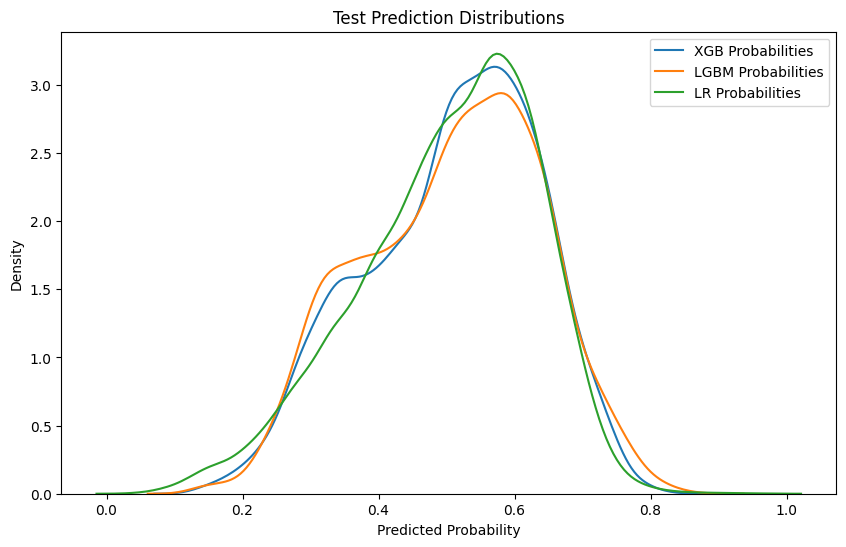

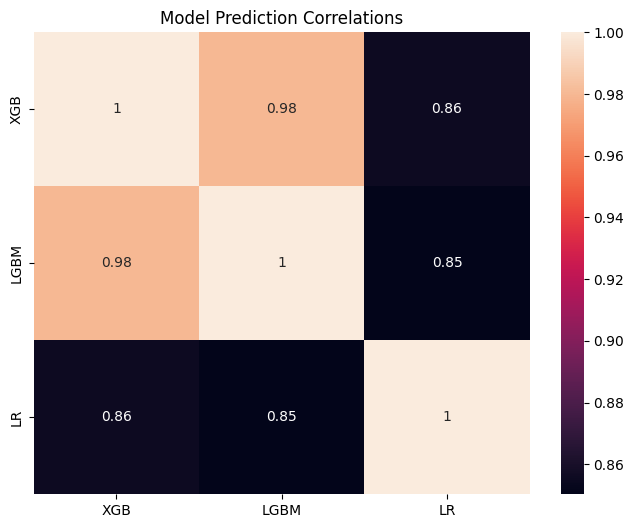

In [35]:
# 1. Validation Performance Metrics
print("\n=== Model Validation Performance ===")
val_metrics = []
for model_name in models:
    y_prob = val_preds[model_name]
    y_pred = (y_prob >= 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(train['target'], y_pred)
    fpr, tpr, _ = roc_curve(train['target'], y_prob)
    auc_score = np.trapz(tpr, fpr)
    
    val_metrics.append({
        'Model': model_name.upper(),
        'AUC': round(auc_score, 4),
        'Accuracy': round(accuracy, 4)
    })

# Convert to DataFrame and display
metrics_df = pd.DataFrame(val_metrics)
print(metrics_df.sort_values('AUC', ascending=False))

# 2. Prediction Distribution Comparison
plt.figure(figsize=(10,6))
for model_name in models:
    sns.kdeplot(test_preds[model_name], label=f'{model_name.upper()} Probabilities')
plt.title('Test Prediction Distributions')
plt.xlabel('Predicted Probability')
plt.legend()
plt.show()

# 4. Correlation Matrix of Predictions
pred_matrix = np.array([test_preds[m] for m in models.keys()])
corr = np.corrcoef(pred_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, 
            xticklabels=[m.upper() for m in models.keys()],
            yticklabels=[m.upper() for m in models.keys()])
plt.title('Model Prediction Correlations')
plt.show()


### **Observation**



1. LGBM is the best model overall based on AUC and accuracy.
2. XGB is a close second, and its predictions are highly similar to LGBM.
3. Logistic Regression performs the worst and has a different prediction pattern.
